In [94]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.constants import c
import importlib
import tools
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [95]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [96]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi

In [97]:
icApi = lumapi.INTERCONNECT()

In [98]:
icApi.switchtolayout()
icApi.deleteall()

In [99]:
#units
nm = 1e-9
um = 1e-6

In [100]:
tools.placeOna(icApi=icApi, x=0, y=0, inputs=2, name='ona1',nmbrofpoints=20000,startFrequency=c/(1530*nm),stopFrequency=c/(1565*nm))

0

In [102]:
for i in range(2):
    icApi.addelement('ebeam_dc_te1550')
    icApi.set('name', f'dc{i+1}')
    icApi.addelement('ebeam_wg_integral_1550')
    icApi.set('name', f'wg{i+1}')

for i in range(4):
    icApi.addelement('ebeam_gc_te1550')
    icApi.set('name', f'gc{i+1}')

icApi.addelement('ebeam_terminator_te1550')
icApi.set('name', 'term1')

icApi.select('wg2')
icApi.set('wg_length', 400*um)

In [103]:
for i in range(2):
    icApi.setposition(f'dc{i+1}', 100*(4*i+1), 200)
    icApi.setposition(f'wg{i+1}', 300, 100*(2*i+1))
    
for j in range(2):
    icApi.setposition(f'gc{j+1}', -100, 100*(2*j+1))
for k in range(2,4,1):
    icApi.flipelement(f'gc{k+1}')
    icApi.setposition(f'gc{k+1}', 700, 100*(2*k-3))
icApi.setposition('term1', -300, 300)

In [104]:
#connections

icApi.connect('ona1', 'output','gc1', 'opt_fiber')
icApi.connect('term1','port 1', 'gc2', 'opt_fiber')

icApi.connect('gc1','opt_wg', 'dc1', 'opt_1')
icApi.connect('gc2','opt_wg', 'dc1', 'opt_2')

icApi.connect('gc3','opt_wg', 'dc2', 'opt_3')
icApi.connect('gc4','opt_wg', 'dc2', 'opt_4')

icApi.connect('dc1','opt_3', 'wg1', 'port 1')
icApi.connect('dc1','opt_4', 'wg2', 'port 1')

icApi.connect('dc2','opt_1', 'wg1', 'port 2')
icApi.connect('dc2','opt_2', 'wg2', 'port 2')

icApi.connect('gc3','opt_fiber', 'ona1', 'input 1')
icApi.connect('gc4','opt_fiber', 'ona1', 'input 2')


1.0

In [105]:
icApi.save('MC_circuit')
icApi.run()

Text(0.5, 1.0, 'Transmission considering average values')

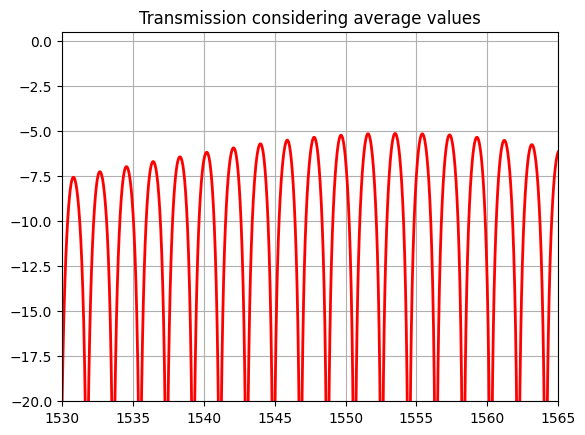

In [106]:
data = icApi.getresult('ona1', 'input 1/mode 1/gain')
plt.plot(data['wavelength']/nm, data["TE gain (dB)"], color='red', linewidth=2)
plt.xlim(1530, 1565)
plt.ylim(-20, 0.5)
plt.grid(True)
plt.title('Transmission considering average values')

## Monte Carlo simulation

In [107]:
icApi.addsweep(2)

'::Monte Carlo analysis'

In [108]:
trials = 10
scriptName = 'Monte Carlo analysis'
icApi.setsweep('Monte Carlo analysis','name', scriptName)
icApi.setsweep('Monte Carlo analysis', 'name', scriptName)
icApi.setsweep(scriptName, 'number of trials', trials)
icApi.setsweep(scriptName, 'enable seed', 1)
icApi.setsweep(scriptName, 'seed', 1)
icApi.setsweep(scriptName, 'Variation', 'Both')

1.0

In [109]:
param = icApi.struct()
param['Name'] = f'wg1_width'
param['Parameter'] = f'::Root Element::wg1::wg_length'
param['Value'] = icApi.getnamed(f'wg1', 'wg_length')
dis = icApi.struct()
dis['type'] = 'gaussian'
dis['variation'] = icApi.getnamed('wg1', 'wg_length')/100
param['Distribution'] = dis
icApi.addsweepparameter(scriptName, param)

'wg1_width'

In [110]:
Tr = icApi.struct()
Tr['Name'] = "Transmission"
Tr['Result'] = f"::Root Element::ona1::input 1/mode 1/gain"
Tr['Estimation'] = True
icApi.addsweepresult(scriptName, Tr)

'Transmission'

In [111]:
icApi.save('mc_sweep')
icApi.runsweep(scriptName)

In [112]:
res = icApi.getsweepresult(scriptName, 'Transmission')
wl = res['wavelength'].flatten()

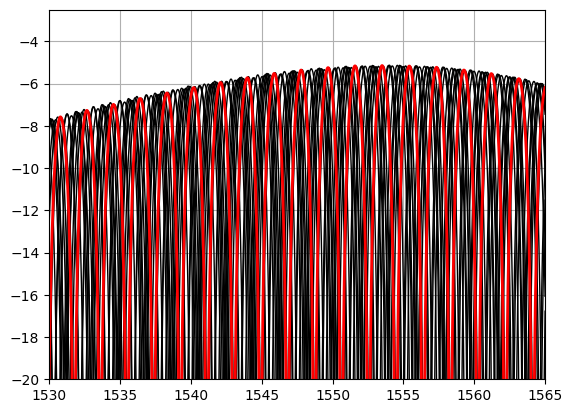

In [114]:
plt.plot(wl / nm, res['TE gain (dB)'], linewidth=1, color='black')
plt.plot(data['wavelength']/nm, data["TE gain (dB)"], color='red', linewidth=2)
plt.xlim(1530, 1565)
plt.ylim(-20, -2.5)
plt.grid()